# Real-Time Conference Registration Forecasting System

This notebook provides real-time forecasting of conference registrations based on current registration data and historical patterns.

**Key Features:**
- Uses current registration data to predict future registrations until event date
- Provides confidence intervals (low/high estimates)
- Matches historical patterns based on target audience
- Real-time updates with fresh data
- Comprehensive risk assessment and insights

In [32]:
# Install and import required libraries
import subprocess
import sys

def install_package(package):
    """Install a package using pip"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError:
        print(f"✗ Failed to install {package}")

# Required packages
required_packages = ["pandas", "numpy", "matplotlib", "scipy", "scikit-learn"]

print("Checking and installing dependencies...")
for package in required_packages:
    try:
        __import__(package.replace("-", "_"))
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)

print("\nDependency check complete!")

Checking and installing dependencies...
✓ pandas already installed
✓ numpy already installed
✓ matplotlib already installed
✓ scipy already installed
Installing scikit-learn...
✓ Successfully installed scikit-learn

Dependency check complete!


In [33]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime, timedelta
import warnings
from typing import Dict, List, Tuple, Optional
import re

warnings.filterwarnings('ignore')
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)

In [34]:
# =============================================================================
# USER INPUT INTERFACE
# =============================================================================

def get_user_inputs():
    """
    Get user inputs for forecasting parameters.
    In a real implementation, this could be a web form or GUI.
    """
    print("=" * 60)
    print("REAL-TIME CONFERENCE REGISTRATION FORECASTING")
    print("=" * 60)
    
    # Target audience selection
    print("\nAvailable Target Audiences:")
    audiences = [
        "Education Managers",
        "Education property managers", 
        "IT MANAGER",
        "Property Managers"
    ]
    
    for i, audience in enumerate(audiences, 1):
        print(f"{i}. {audience}")
    print(f"{len(audiences) + 1}. None of the above (use all historical data)")
    
    # For demo purposes, we'll use predefined values
    # In real implementation, these would be user inputs
    selected_audience_idx = 5  # Change this to test different audiences
    event_date = "15/08/2025"  # Event date (DD/MM/YYYY)
    marketing_start_date = "01/07/2025"  # Marketing start date (DD/MM/YYYY)
    
    print(f"\n[DEMO] Selected audience: {selected_audience_idx}")
    print(f"[DEMO] Event date: {event_date}")
    print(f"[DEMO] Marketing start date: {marketing_start_date}")
    
    # Process selection
    if selected_audience_idx <= len(audiences):
        target_audience = audiences[selected_audience_idx - 1]
        use_all_data = False
    else:
        target_audience = "All Audiences"
        use_all_data = True
    
    return {
        'target_audience': target_audience,
        'use_all_data': use_all_data,
        'event_date': event_date,
        'marketing_start_date': marketing_start_date,
        'current_date': datetime.now().strftime("%d/%m/%Y")
    }

# Get user inputs
user_config = get_user_inputs()
print(f"\nConfiguration loaded: {user_config}")

REAL-TIME CONFERENCE REGISTRATION FORECASTING

Available Target Audiences:
1. Education Managers
2. Education property managers
3. IT MANAGER
4. Property Managers
5. None of the above (use all historical data)

[DEMO] Selected audience: 5
[DEMO] Event date: 15/08/2025
[DEMO] Marketing start date: 01/07/2025

Configuration loaded: {'target_audience': 'All Audiences', 'use_all_data': True, 'event_date': '15/08/2025', 'marketing_start_date': '01/07/2025', 'current_date': '20/07/2025'}


In [35]:
# =============================================================================
# DATA LOADING AND PROCESSING 
# =============================================================================

def parse_date(date_str: str) -> datetime:
    """Parse date string in DD/MM/YYYY format"""
    try:
        return datetime.strptime(date_str.strip(), "%d/%m/%Y")
    except ValueError:
        try:
            return datetime.strptime(date_str.strip(), "%Y-%m-%d")
        except ValueError:
            print(f"Warning: Could not parse date '{date_str}'")
            return None

def load_current_registrations() -> pd.DataFrame:
    """
    Load current registration data from sample_data.csv
    """
    try:
        df = pd.read_csv('sample_data.csv')
        df['CreatedDate'] = df['Created Date'].apply(parse_date)
        df = df.dropna(subset=['CreatedDate'])
        print(f"✓ Loaded {len(df)} current registrations from sample_data.csv")
        return df
    except Exception as e:
        print(f"✗ Error loading current registrations: {e}")
        return pd.DataFrame()

def load_historical_patterns(target_audience: str, use_all_data: bool) -> Dict:
    """
    Load historical patterns from ONLY Cleaned_Dataset.csv files.
    Completely ignores SourceFile column and other CSV files.
    """
    base_path = "CONF. DATASET"
    
    if not os.path.exists(base_path):
        return {'error': f'Dataset directory "{base_path}" not found'}
    
    # Define audience folder mapping
    audience_folders = {
        "Education Managers": "Education Managers",
        "Education property managers": "Education property managers", 
        "IT MANAGER": "IT MANAGER",
        "Property Managers": "Property Managers"
    }
    
    events = []
    
    if use_all_data:
        # Load from all audience folders
        folders_to_check = list(audience_folders.values())
    else:
        # Load only from target audience folder
        if target_audience in audience_folders:
            folders_to_check = [audience_folders[target_audience]]
        else:
            return {'error': f'Unknown target audience: {target_audience}'}
    
    for folder in folders_to_check:
        folder_path = os.path.join(base_path, folder)
        
        if not os.path.exists(folder_path):
            print(f"Warning: Folder '{folder}' not found, skipping...")
            continue
        
        # ONLY load Cleaned_Dataset.csv - ignore all other CSV files
        cleaned_file = os.path.join(folder_path, "Cleaned_Dataset.csv")
        
        if not os.path.exists(cleaned_file):
            print(f"Warning: No Cleaned_Dataset.csv found in '{folder}', skipping...")
            continue
        
        try:
            # Load the cleaned dataset
            df = pd.read_csv(cleaned_file)
            
            # COMPLETELY IGNORE SourceFile column - drop it if it exists
            if 'SourceFile' in df.columns:
                df = df.drop('SourceFile', axis=1)
            
            # Process the data (focusing only on registration patterns)
            if 'CreatedDate' in df.columns:
                df['CreatedDate'] = df['CreatedDate'].apply(parse_date)
                df = df.dropna(subset=['CreatedDate'])
                
                if len(df) > 0:
                    # Calculate registration timeline
                    df = df.sort_values('CreatedDate')
                    start_date = df['CreatedDate'].min()
                    end_date = df['CreatedDate'].max()
                    
                    # Calculate weeks since start for each registration
                    df['WeeksSinceStart'] = (df['CreatedDate'] - start_date).dt.days // 7
                    
                    # Group by weeks
                    weekly_counts = df.groupby('WeeksSinceStart').size().reset_index()
                    weekly_counts.columns = ['Week', 'Registrations']
                    
                    # Fill missing weeks with 0
                    if len(weekly_counts) > 0:
                        max_week = weekly_counts['Week'].max()
                        all_weeks = pd.DataFrame({'Week': range(0, max_week + 1)})
                        weekly_counts = all_weeks.merge(weekly_counts, on='Week', how='left').fillna(0)
                    
                    weekly_counts['CumulativeRegistrations'] = weekly_counts['Registrations'].cumsum()
                    
                    # Create event record (pattern-focused, no file references)
                    event_data = {
                        'audience': folder,
                        'total_registrations': len(df),
                        'duration_weeks': int(weekly_counts['Week'].max()) if len(weekly_counts) > 0 else 0,
                        'weekly_data': weekly_counts,
                        'date_range': f"{start_date.strftime('%d/%m/%Y')} to {end_date.strftime('%d/%m/%Y')}"
                    }
                    
                    events.append(event_data)
                    print(f"✓ Loaded pattern from {folder}: {len(df)} registrations over {event_data['duration_weeks']} weeks")
                
        except Exception as e:
            print(f"✗ Error loading {cleaned_file}: {e}")
            continue
    
    if len(events) == 0:
        return {'error': 'No valid historical patterns found in cleaned datasets'}
    
    return {
        'events': events,
        'total_events': len(events),
        'audiences_covered': list(set([e['audience'] for e in events]))
    }

def calculate_date_info(event_date: str, marketing_start_date: str, current_date: str) -> Dict:
    """
    Calculate date-related information for forecasting
    """
    try:
        event_dt = parse_date(event_date)
        marketing_start_dt = parse_date(marketing_start_date)
        current_dt = parse_date(current_date)
        
        if None in [event_dt, marketing_start_dt, current_dt]:
            return {'error': 'Invalid date format. Use DD/MM/YYYY'}
        
        total_days = (event_dt - marketing_start_dt).days
        elapsed_days = (current_dt - marketing_start_dt).days
        remaining_days = (event_dt - current_dt).days
        
        weeks_elapsed = elapsed_days // 7
        weeks_remaining = max(0, remaining_days // 7)
        total_weeks = total_days // 7
        
        completion_percentage = (elapsed_days / max(total_days, 1)) * 100
        
        return {
            'marketing_start': marketing_start_dt,
            'event_date': event_dt,
            'current_date': current_dt,
            'total_days': total_days,
            'elapsed_days': elapsed_days,
            'remaining_days': remaining_days,
            'weeks_elapsed': weeks_elapsed,
            'weeks_remaining': weeks_remaining,
            'total_weeks': total_weeks,
            'completion_percentage': completion_percentage
        }
        
    except Exception as e:
        return {'error': f'Date calculation error: {e}'}

# Load data based on user configuration
print("Loading data...")

# Load current registrations
current_registrations = load_current_registrations()

# Load historical patterns (ONLY from Cleaned_Dataset.csv files)
historical_analysis = load_historical_patterns(
    user_config['target_audience'], 
    user_config['use_all_data']
)

# Calculate date information
date_info = calculate_date_info(
    user_config['event_date'],
    user_config['marketing_start_date'], 
    user_config['current_date']
)

# Display summary
print(f"\nData Loading Summary:")
print(f"✓ Current registrations: {len(current_registrations)} records")

if 'error' not in historical_analysis:
    print(f"✓ Historical patterns: {historical_analysis['total_events']} patterns from cleaned datasets")
    print(f"✓ Audiences covered: {', '.join(historical_analysis['audiences_covered'])}")
else:
    print(f"✗ Historical patterns: {historical_analysis['error']}")

if 'error' not in date_info:
    print(f"✓ Campaign timeline: {date_info['weeks_elapsed']} weeks elapsed, {date_info['weeks_remaining']} weeks remaining")
else:
    print(f"✗ Date calculation: {date_info['error']}")

print(f"\nNote: System uses ONLY Cleaned_Dataset.csv files and ignores SourceFile column completely.")

Loading data...
✓ Loaded 179 current registrations from sample_data.csv
✓ Loaded pattern from Education Managers: 1751 registrations over 69 weeks
✓ Loaded pattern from Education property managers: 1601 registrations over 11 weeks
✓ Loaded pattern from IT MANAGER: 2251 registrations over 272 weeks
✓ Loaded pattern from Property Managers: 1827 registrations over 247 weeks

Data Loading Summary:
✓ Current registrations: 179 records
✓ Historical patterns: 4 patterns from cleaned datasets
✓ Audiences covered: Education Managers, IT MANAGER, Property Managers, Education property managers
✓ Campaign timeline: 2 weeks elapsed, 3 weeks remaining

Note: System uses ONLY Cleaned_Dataset.csv files and ignores SourceFile column completely.


In [36]:
# =============================================================================
# CURRENT REGISTRATION ANALYSIS
# =============================================================================

def analyze_current_registrations(df: pd.DataFrame, marketing_start: datetime) -> Dict:
    """
    Analyze current registration patterns.
    """
    if len(df) == 0:
        return {'error': 'No current registration data available'}
    
    # Calculate weeks since marketing start for each registration
    df = df.copy()
    df['WeeksSinceStart'] = (df['CreatedDate'] - marketing_start).dt.days // 7
    
    # Group by weeks
    weekly_counts = df.groupby('WeeksSinceStart').size().reset_index()
    weekly_counts.columns = ['Week', 'Registrations']
    
    # Fill missing weeks with 0
    if len(weekly_counts) > 0:
        max_week = weekly_counts['Week'].max()
        all_weeks = pd.DataFrame({'Week': range(0, max_week + 1)})
        weekly_counts = all_weeks.merge(weekly_counts, on='Week', how='left').fillna(0)
    
    # Calculate cumulative
    weekly_counts['CumulativeRegistrations'] = weekly_counts['Registrations'].cumsum()
    
    # Calculate statistics
    total_registrations = len(df)
    avg_daily_rate = total_registrations / max(1, (datetime.now() - marketing_start).days)
    avg_weekly_rate = avg_daily_rate * 7
    
    # Registration velocity (recent trend)
    if len(weekly_counts) >= 2:
        recent_weeks = weekly_counts.tail(2)
        recent_velocity = recent_weeks['Registrations'].mean()
    else:
        recent_velocity = weekly_counts['Registrations'].mean() if len(weekly_counts) > 0 else 0
    
    return {
        'weekly_data': weekly_counts,
        'total_registrations': total_registrations,
        'avg_weekly_rate': avg_weekly_rate,
        'recent_velocity': recent_velocity,
        'registration_dates': {
            'first': df['CreatedDate'].min(),
            'last': df['CreatedDate'].max(),
            'span_days': (df['CreatedDate'].max() - df['CreatedDate'].min()).days
        }
    }

# Analyze current registrations
current_analysis = analyze_current_registrations(current_registrations, date_info['marketing_start'])

if 'error' not in current_analysis:
    print("\nCurrent Registration Analysis:")
    print(f"  Total registrations so far: {current_analysis['total_registrations']}")
    print(f"  Average weekly rate: {current_analysis['avg_weekly_rate']:.1f} registrations/week")
    print(f"  Recent velocity: {current_analysis['recent_velocity']:.1f} registrations/week")
    print(f"  Registration span: {current_analysis['registration_dates']['span_days']} days")
    
    print("\nWeekly breakdown:")
    print(current_analysis['weekly_data'].to_string(index=False))
else:
    print(f"\nError in current analysis: {current_analysis['error']}")


Current Registration Analysis:
  Total registrations so far: 179
  Average weekly rate: 65.9 registrations/week
  Recent velocity: 57.5 registrations/week
  Registration span: 16 days

Weekly breakdown:
 Week  Registrations  CumulativeRegistrations
    0             64                       64
    1             80                      144
    2             35                      179


In [37]:
# =============================================================================
# EXTERNAL FACTORS ANALYSIS (UK HOLIDAYS & COVID IMPACT)
# =============================================================================

def get_uk_bank_holidays(year: int) -> List[datetime]:
    """
    Get UK bank holidays for a given year.
    Based on standard UK bank holiday schedule.
    """
    import calendar
    
    holidays = []
    
    # New Year's Day
    new_year = datetime(year, 1, 1)
    if new_year.weekday() == 6:  # Sunday
        holidays.append(datetime(year, 1, 2))  # Monday substitute
    elif new_year.weekday() == 5:  # Saturday
        holidays.append(datetime(year, 1, 3))  # Monday substitute
    else:
        holidays.append(new_year)
    
    # Easter calculation (simplified - for production use proper Easter algorithm)
    easter_dates = {
        2019: datetime(2019, 4, 21),
        2020: datetime(2020, 4, 12),
        2021: datetime(2021, 4, 4),
        2022: datetime(2022, 4, 17),
        2023: datetime(2023, 4, 9),
        2024: datetime(2024, 3, 31),
        2025: datetime(2025, 4, 20)
    }
    
    if year in easter_dates:
        easter = easter_dates[year]
        holidays.append(easter - timedelta(days=2))  # Good Friday
        holidays.append(easter + timedelta(days=1))  # Easter Monday
    
    # Early May bank holiday (first Monday in May)
    may_1 = datetime(year, 5, 1)
    days_to_monday = (7 - may_1.weekday()) % 7
    if days_to_monday == 0:
        days_to_monday = 7
    holidays.append(may_1 + timedelta(days=days_to_monday))
    
    # Spring bank holiday (last Monday in May)
    may_31 = datetime(year, 5, 31)
    days_back_to_monday = (may_31.weekday() + 1) % 7
    holidays.append(may_31 - timedelta(days=days_back_to_monday))
    
    # Summer bank holiday (last Monday in August)
    aug_31 = datetime(year, 8, 31)
    days_back_to_monday = (aug_31.weekday() + 1) % 7
    holidays.append(aug_31 - timedelta(days=days_back_to_monday))
    
    # Christmas holidays
    christmas = datetime(year, 12, 25)
    boxing_day = datetime(year, 12, 26)
    
    # Add Christmas and Boxing Day with weekend substitutions
    if christmas.weekday() == 5:  # Saturday
        holidays.append(datetime(year, 12, 27))  # Monday substitute
        holidays.append(datetime(year, 12, 28))  # Tuesday substitute
    elif christmas.weekday() == 6:  # Sunday
        holidays.append(datetime(year, 12, 26))  # Monday substitute
        holidays.append(datetime(year, 12, 27))  # Tuesday substitute
    else:
        holidays.append(christmas)
        if boxing_day.weekday() == 6:  # Sunday
            holidays.append(datetime(year, 12, 27))  # Monday substitute
        else:
            holidays.append(boxing_day)
    
    return sorted(holidays)

def identify_covid_periods() -> Dict:
    """
    Define COVID-19 impact periods for the UK.
    """
    return {
        'lockdown_1': {
            'start': datetime(2020, 3, 23),
            'end': datetime(2020, 7, 4),
            'impact_factor': 0.3,  # 70% reduction in normal activity
            'description': 'First UK lockdown'
        },
        'restrictions_summer_2020': {
            'start': datetime(2020, 7, 5),
            'end': datetime(2020, 11, 4),
            'impact_factor': 0.7,  # 30% reduction
            'description': 'Relaxed restrictions with social distancing'
        },
        'lockdown_2': {
            'start': datetime(2020, 11, 5),
            'end': datetime(2020, 12, 1),
            'impact_factor': 0.4,  # 60% reduction
            'description': 'Second UK lockdown'
        },
        'tier_system': {
            'start': datetime(2020, 12, 2),
            'end': datetime(2021, 1, 5),
            'impact_factor': 0.6,  # 40% reduction
            'description': 'Tier system and Christmas restrictions'
        },
        'lockdown_3': {
            'start': datetime(2021, 1, 6),
            'end': datetime(2021, 4, 11),
            'impact_factor': 0.2,  # 80% reduction
            'description': 'Third UK lockdown'
        },
        'gradual_reopening': {
            'start': datetime(2021, 4, 12),
            'end': datetime(2021, 7, 18),
            'impact_factor': 0.8,  # 20% reduction
            'description': 'Gradual reopening with restrictions'
        },
        'freedom_day': {
            'start': datetime(2021, 7, 19),
            'end': datetime(2021, 12, 31),
            'impact_factor': 0.95,  # Near normal
            'description': 'Most restrictions lifted'
        },
        'post_covid_adjustment': {
            'start': datetime(2022, 1, 1),
            'end': datetime(2022, 12, 31),
            'impact_factor': 1.0,  # Normal activity resumed
            'description': 'Post-COVID adjustment period'
        }
    }

def analyze_external_factors(df: pd.DataFrame) -> Dict:
    """
    Analyze the impact of external factors on registration patterns.
    """
    if len(df) == 0 or 'CreatedDate' not in df.columns:
        return {'error': 'No valid data for external factor analysis'}
    
    df = df.copy()
    df['CreatedDate'] = pd.to_datetime(df['CreatedDate'])
    
    # Get date range
    start_date = df['CreatedDate'].min()
    end_date = df['CreatedDate'].max()
    years = range(start_date.year, end_date.year + 1)
    
    # Collect all holidays in the date range
    all_holidays = []
    for year in years:
        all_holidays.extend(get_uk_bank_holidays(year))
    
    # COVID periods
    covid_periods = identify_covid_periods()
    
    # Analyze holiday impact
    holiday_analysis = {}
    for holiday in all_holidays:
        if start_date <= holiday <= end_date:
            # Look at registrations 7 days before and after holiday
            before_window = (holiday - timedelta(days=7), holiday - timedelta(days=1))
            after_window = (holiday + timedelta(days=1), holiday + timedelta(days=7))
            
            before_count = len(df[(df['CreatedDate'] >= before_window[0]) & 
                                (df['CreatedDate'] <= before_window[1])])
            after_count = len(df[(df['CreatedDate'] >= after_window[0]) & 
                               (df['CreatedDate'] <= after_window[1])])
            
            holiday_analysis[holiday.strftime('%Y-%m-%d')] = {
                'before_registrations': before_count,
                'after_registrations': after_count,
                'impact_ratio': after_count / max(before_count, 1)
            }
    
    # Analyze COVID impact
    covid_analysis = {}
    for period_name, period_info in covid_periods.items():
        period_data = df[(df['CreatedDate'] >= period_info['start']) & 
                        (df['CreatedDate'] <= period_info['end'])]
        
        if len(period_data) > 0:
            # Calculate registration rate during period
            days_in_period = (period_info['end'] - period_info['start']).days
            registrations_per_day = len(period_data) / max(days_in_period, 1)
            
            covid_analysis[period_name] = {
                'registrations': len(period_data),
                'days': days_in_period,
                'rate_per_day': registrations_per_day,
                'expected_impact_factor': period_info['impact_factor'],
                'description': period_info['description']
            }
    
    # Calculate baseline registration rate (non-COVID periods)
    non_covid_data = df.copy()
    for period_info in covid_periods.values():
        if period_info['start'] <= end_date and period_info['end'] >= start_date:
            non_covid_data = non_covid_data[~((non_covid_data['CreatedDate'] >= period_info['start']) & 
                                             (non_covid_data['CreatedDate'] <= period_info['end']))]
    
    baseline_rate = len(non_covid_data) / max((end_date - start_date).days - 
                                             sum((p['end'] - p['start']).days for p in covid_periods.values() 
                                                 if p['start'] <= end_date and p['end'] >= start_date), 1)
    
    return {
        'holiday_impact': holiday_analysis,
        'covid_impact': covid_analysis,
        'baseline_daily_rate': baseline_rate,
        'total_holidays_in_period': len([h for h in all_holidays if start_date <= h <= end_date]),
        'covid_affected_registrations': sum(c['registrations'] for c in covid_analysis.values()),
        'date_range': f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}"
    }

print("External factors analysis functions loaded...")
print("Available functions:")
print("- get_uk_bank_holidays(year): Get UK bank holidays for a specific year")
print("- identify_covid_periods(): Get COVID-19 impact periods")
print("- analyze_external_factors(df): Analyze holiday and COVID impacts on registration data")

External factors analysis functions loaded...
Available functions:
- get_uk_bank_holidays(year): Get UK bank holidays for a specific year
- identify_covid_periods(): Get COVID-19 impact periods
- analyze_external_factors(df): Analyze holiday and COVID impacts on registration data


In [38]:
# =============================================================================
# ENHANCED PATTERN MATCHING WITH EXTERNAL FACTORS
# =============================================================================

def analyze_historical_patterns_with_external_factors(historical_data: Dict) -> Dict:
    """
    Analyze historical patterns for external factor impacts (holidays, COVID).
    """
    if 'error' in historical_data:
        return {'error': 'No historical data available'}
    
    enhanced_patterns = []
    
    for pattern in historical_data['events']:
        # Load the raw data for this pattern
        audience = pattern['audience']
        folder_path = os.path.join("CONF. DATASET", audience)
        cleaned_file = os.path.join(folder_path, "Cleaned_Dataset.csv")
        
        if os.path.exists(cleaned_file):
            try:
                df = pd.read_csv(cleaned_file)
                if 'SourceFile' in df.columns:
                    df = df.drop('SourceFile', axis=1)
                
                # Analyze external factors for this pattern
                external_analysis = analyze_external_factors(df)
                
                # Enhanced pattern with external factor analysis
                enhanced_pattern = pattern.copy()
                enhanced_pattern['external_factors'] = external_analysis
                
                # Calculate external factor adjustments
                if 'error' not in external_analysis:
                    covid_impact = external_analysis.get('covid_impact', {})
                    holiday_impact = external_analysis.get('holiday_impact', {})
                    
                    # Determine if this pattern was significantly affected by external factors
                    total_covid_registrations = sum(c['registrations'] for c in covid_impact.values())
                    covid_affected = total_covid_registrations > (pattern['total_registrations'] * 0.1)
                    
                    holiday_effects = [h['impact_ratio'] for h in holiday_impact.values()]
                    avg_holiday_impact = np.mean(holiday_effects) if holiday_effects else 1.0
                    
                    enhanced_pattern['covid_affected'] = covid_affected
                    enhanced_pattern['holiday_impact_ratio'] = avg_holiday_impact
                    enhanced_pattern['baseline_rate'] = external_analysis.get('baseline_daily_rate', 0)
                
                enhanced_patterns.append(enhanced_pattern)
                
            except Exception as e:
                print(f"Warning: Could not analyze external factors for {audience}: {e}")
                enhanced_patterns.append(pattern)
        else:
            enhanced_patterns.append(pattern)
    
    return {
        'events': enhanced_patterns,
        'total_events': len(enhanced_patterns),
        'audiences_covered': list(set([e['audience'] for e in enhanced_patterns]))
    }

def check_current_external_factors(event_date: str, current_date: str) -> Dict:
    """
    Check for external factors that might affect current/future registrations.
    """
    try:
        event_dt = parse_date(event_date)
        current_dt = parse_date(current_date)
        
        if None in [event_dt, current_dt]:
            return {'error': 'Invalid date format'}
        
        # Check for holidays between now and event
        years = range(current_dt.year, event_dt.year + 1)
        upcoming_holidays = []
        for year in years:
            holidays = get_uk_bank_holidays(year)
            for holiday in holidays:
                if current_dt <= holiday <= event_dt:
                    upcoming_holidays.append(holiday)
        
        # Check for COVID-like external factors (future-proofing)
        external_warnings = []
        if (event_dt - current_dt).days < 30:
            external_warnings.append("Short timeline - limited adjustment time for external factors")
        
        # Holiday proximity warnings
        for holiday in upcoming_holidays:
            days_to_holiday = (holiday - current_dt).days
            if days_to_holiday < 7:
                external_warnings.append(f"UK bank holiday approaching: {holiday.strftime('%d %B %Y')}")
        
        return {
            'upcoming_holidays': [h.strftime('%d %B %Y') for h in upcoming_holidays],
            'holiday_count': len(upcoming_holidays),
            'warnings': external_warnings,
            'recommendations': []
        }
        
    except Exception as e:
        return {'error': f'External factor check failed: {e}'}

def find_best_matching_patterns_enhanced(current_data: Dict, historical_data: Dict, 
                                       weeks_elapsed: int, external_factors: Dict) -> List[Dict]:
    """
    Enhanced pattern matching that considers external factors.
    """
    if 'error' in current_data or 'error' in historical_data:
        return []
    
    current_total = current_data['total_registrations']
    current_weekly = current_data['weekly_data']
    
    matches = []
    
    for pattern in historical_data['events']:
        # Only consider patterns that have data for the current week period
        if pattern['duration_weeks'] > weeks_elapsed:
            historical_weekly = pattern['weekly_data']
            
            # Get registrations up to current week for both datasets
            current_partial = current_weekly[current_weekly['Week'] <= weeks_elapsed]['CumulativeRegistrations'].iloc[-1] if len(current_weekly) > 0 else 0
            historical_partial = historical_weekly[historical_weekly['Week'] <= weeks_elapsed]['CumulativeRegistrations'].iloc[-1] if len(historical_weekly) > weeks_elapsed else 0
            
            if historical_partial > 0:
                # Calculate scaling factor
                scale_factor = current_partial / historical_partial
                
                # Calculate similarity score based on weekly pattern
                similarity_scores = []
                for week in range(min(weeks_elapsed + 1, len(current_weekly), len(historical_weekly))):
                    if week < len(current_weekly) and week < len(historical_weekly):
                        current_week_reg = current_weekly.iloc[week]['Registrations']
                        historical_week_reg = historical_weekly.iloc[week]['Registrations'] * scale_factor
                        
                        if current_week_reg + historical_week_reg > 0:
                            similarity = 1 - abs(current_week_reg - historical_week_reg) / (current_week_reg + historical_week_reg)
                            similarity_scores.append(max(0, similarity))
                
                avg_similarity = np.mean(similarity_scores) if similarity_scores else 0
                
                # Apply external factor adjustments
                external_adjustment = 1.0
                confidence_modifier = 1.0
                
                # COVID adjustment
                if pattern.get('covid_affected', False):
                    external_adjustment *= 0.9  # Slightly reduce confidence in COVID-affected patterns
                    confidence_modifier *= 0.95
                
                # Holiday adjustment
                holiday_ratio = pattern.get('holiday_impact_ratio', 1.0)
                if abs(holiday_ratio - 1.0) > 0.2:  # Significant holiday impact
                    confidence_modifier *= 0.9
                
                # Current external factor adjustments
                if 'upcoming_holidays' in external_factors:
                    if external_factors['holiday_count'] > 2:
                        external_adjustment *= 0.95  # Expect some impact from multiple holidays
                
                adjusted_prediction = pattern['total_registrations'] * scale_factor * external_adjustment
                adjusted_similarity = avg_similarity * confidence_modifier
                
                matches.append({
                    'pattern': pattern,
                    'scale_factor': scale_factor,
                    'similarity_score': adjusted_similarity,
                    'predicted_final': adjusted_prediction,
                    'external_adjustment': external_adjustment,
                    'covid_affected': pattern.get('covid_affected', False),
                    'holiday_impact': pattern.get('holiday_impact_ratio', 1.0)
                })
    
    # Sort by adjusted similarity score
    matches.sort(key=lambda x: x['similarity_score'], reverse=True)
    
    return matches

# Enhanced analysis with external factors
print("Analyzing historical patterns with external factors...")
enhanced_historical = analyze_historical_patterns_with_external_factors(historical_analysis)

# Check current external factors
current_external_factors = check_current_external_factors(
    user_config['event_date'], 
    user_config['current_date']
)

# Enhanced pattern matching
enhanced_matching_patterns = find_best_matching_patterns_enhanced(
    current_analysis, enhanced_historical, date_info['weeks_elapsed'], current_external_factors
)

if enhanced_matching_patterns:
    print("\nEnhanced Pattern Matching Results (with External Factors):")
    for i, match in enumerate(enhanced_matching_patterns[:3], 1):
        pattern = match['pattern']
        print(f"\n{i}. Historical Pattern {i} ({pattern['audience']})")
        print(f"   Pattern timeframe: {pattern.get('date_range', 'Multiple periods')}")
        print(f"   Historical total: {pattern['total_registrations']} registrations")
        print(f"   Similarity score: {match['similarity_score']:.3f}")
        print(f"   Scale factor: {match['scale_factor']:.2f}")
        print(f"   External adjustment: {match['external_adjustment']:.2f}")
        print(f"   COVID affected: {'Yes' if match['covid_affected'] else 'No'}")
        print(f"   Holiday impact: {match['holiday_impact']:.2f}")
        print(f"   Adjusted prediction: {match['predicted_final']:.0f} registrations")
else:
    print("\nNo suitable enhanced patterns found for matching.")

# Display current external factor analysis
if 'error' not in current_external_factors:
    print(f"\nCurrent External Factors Analysis:")
    print(f"  Upcoming holidays: {len(current_external_factors['upcoming_holidays'])}")
    for holiday in current_external_factors['upcoming_holidays']:
        print(f"    - {holiday}")
    
    if current_external_factors['warnings']:
        print(f"  Warnings:")
        for warning in current_external_factors['warnings']:
            print(f"    ⚠️ {warning}")
else:
    print(f"\nExternal factors check failed: {current_external_factors['error']}")

# Use enhanced patterns for further analysis
matching_patterns = enhanced_matching_patterns

Analyzing historical patterns with external factors...

Enhanced Pattern Matching Results (with External Factors):

1. Historical Pattern 1 (Education Managers)
   Pattern timeframe: 16/03/2022 to 18/07/2023
   Historical total: 1751 registrations
   Similarity score: 0.652
   Scale factor: 0.46
   External adjustment: 0.90
   COVID affected: Yes
   Holiday impact: 0.66
   Adjusted prediction: 718 registrations

2. Historical Pattern 2 (Education property managers)
   Pattern timeframe: 19/01/2021 to 09/04/2021
   Historical total: 1601 registrations
   Similarity score: 0.636
   Scale factor: 0.67
   External adjustment: 0.90
   COVID affected: Yes
   Holiday impact: 0.40
   Adjusted prediction: 970 registrations

3. Historical Pattern 3 (IT MANAGER)
   Pattern timeframe: 16/07/2019 to 04/10/2024
   Historical total: 2251 registrations
   Similarity score: 0.401
   Scale factor: 0.66
   External adjustment: 0.90
   COVID affected: Yes
   Holiday impact: 0.29
   Adjusted prediction: 13

In [39]:
# =============================================================================
# ENHANCED ML PREDICTION ENGINE WITH EXTERNAL FACTORS
# =============================================================================

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def create_external_factor_features(date: datetime, covid_periods: Dict, holidays: List[datetime]) -> Dict:
    """
    Create feature vector for a given date incorporating external factors.
    """
    features = {
        'month': date.month,
        'day_of_week': date.weekday(),
        'day_of_year': date.timetuple().tm_yday,
        'is_weekend': 1 if date.weekday() >= 5 else 0,
        'is_holiday': 0,
        'days_to_holiday': 999,
        'days_from_holiday': 999,
        'covid_impact_factor': 1.0,
        'in_covid_period': 0,
        'quarter': (date.month - 1) // 3 + 1
    }
    
    # Holiday features
    for holiday in holidays:
        days_diff = (holiday - date).days
        if abs(days_diff) <= 7:  # Within a week of holiday
            if days_diff == 0:
                features['is_holiday'] = 1
            features['days_to_holiday'] = min(features['days_to_holiday'], abs(days_diff))
            features['days_from_holiday'] = min(features['days_from_holiday'], abs(days_diff))
    
    # COVID features
    for period_name, period_info in covid_periods.items():
        if period_info['start'] <= date <= period_info['end']:
            features['covid_impact_factor'] = period_info['impact_factor']
            features['in_covid_period'] = 1
            break
    
    return features

def prepare_training_data_with_external_factors(historical_data: Dict) -> Dict:
    """
    Prepare training data that includes external factor features.
    """
    if 'error' in historical_data:
        return {'error': 'No historical data available'}
    
    training_samples = []
    
    for pattern in historical_data['events']:
        audience = pattern['audience']
        folder_path = os.path.join("CONF. DATASET", audience)
        cleaned_file = os.path.join(folder_path, "Cleaned_Dataset.csv")
        
        if os.path.exists(cleaned_file):
            try:
                df = pd.read_csv(cleaned_file)
                if 'SourceFile' in df.columns:
                    df = df.drop('SourceFile', axis=1)
                
                df['CreatedDate'] = df['CreatedDate'].apply(parse_date)
                df = df.dropna(subset=['CreatedDate'])
                df = df.sort_values('CreatedDate')
                
                if len(df) > 0:
                    start_date = df['CreatedDate'].min()
                    end_date = df['CreatedDate'].max()
                    
                    # Get holidays for this period
                    years = range(start_date.year, end_date.year + 1)
                    holidays = []
                    for year in years:
                        holidays.extend(get_uk_bank_holidays(year))
                    
                    covid_periods = identify_covid_periods()
                    
                    # Create weekly samples
                    df['WeeksSinceStart'] = (df['CreatedDate'] - start_date).dt.days // 7
                    weekly_counts = df.groupby('WeeksSinceStart').size().reset_index()
                    weekly_counts.columns = ['Week', 'Registrations']
                    
                    # Fill missing weeks
                    if len(weekly_counts) > 0:
                        max_week = weekly_counts['Week'].max()
                        all_weeks = pd.DataFrame({'Week': range(0, max_week + 1)})
                        weekly_counts = all_weeks.merge(weekly_counts, on='Week', how='left').fillna(0)
                    
                    weekly_counts['CumulativeRegistrations'] = weekly_counts['Registrations'].cumsum()
                    
                    # Create training samples for each week
                    for _, week_row in weekly_counts.iterrows():
                        week_num = int(week_row['Week'])
                        week_date = start_date + timedelta(weeks=week_num)
                        
                        # External factor features
                        ext_features = create_external_factor_features(week_date, covid_periods, holidays)
                        
                        # Target variables
                        weekly_registrations = week_row['Registrations']
                        cumulative_registrations = week_row['CumulativeRegistrations']
                        
                        # Event features
                        total_event_registrations = len(df)
                        weeks_into_campaign = week_num
                        total_campaign_weeks = max_week
                        completion_ratio = weeks_into_campaign / max(total_campaign_weeks, 1)
                        
                        sample = {
                            **ext_features,
                            'audience_type': audience,
                            'weeks_into_campaign': weeks_into_campaign,
                            'total_campaign_weeks': total_campaign_weeks,
                            'completion_ratio': completion_ratio,
                            'cumulative_registrations': cumulative_registrations,
                            'weekly_registrations': weekly_registrations,
                            'total_event_registrations': total_event_registrations
                        }
                        
                        training_samples.append(sample)
                        
            except Exception as e:
                print(f"Warning: Could not process {audience} for training data: {e}")
                continue
    
    if len(training_samples) == 0:
        return {'error': 'No training samples generated'}
    
    return {
        'samples': training_samples,
        'total_samples': len(training_samples),
        'audiences': list(set([s['audience_type'] for s in training_samples]))
    }

def train_enhanced_prediction_models(training_data: Dict) -> Dict:
    """
    Train machine learning models with external factor features.
    """
    if 'error' in training_data:
        return {'error': 'No training data available'}
    
    samples = training_data['samples']
    
    # Prepare feature matrix
    feature_names = ['month', 'day_of_week', 'day_of_year', 'is_weekend', 'is_holiday', 
                    'days_to_holiday', 'days_from_holiday', 'covid_impact_factor', 
                    'in_covid_period', 'quarter', 'weeks_into_campaign', 
                    'total_campaign_weeks', 'completion_ratio']
    
    # Encode categorical features
    audience_encoding = {aud: i for i, aud in enumerate(training_data['audiences'])}
    
    X = []
    y_weekly = []
    y_cumulative = []
    y_final = []
    
    for sample in samples:
        features = [sample[fname] for fname in feature_names]
        features.append(audience_encoding[sample['audience_type']])  # Add encoded audience
        
        X.append(features)
        y_weekly.append(sample['weekly_registrations'])
        y_cumulative.append(sample['cumulative_registrations'])
        y_final.append(sample['total_event_registrations'])
    
    feature_names.append('audience_encoded')
    
    X = np.array(X)
    y_weekly = np.array(y_weekly)
    y_cumulative = np.array(y_cumulative)
    y_final = np.array(y_final)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train multiple models
    models = {}
    
    # Weekly registrations prediction
    rf_weekly = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_weekly.fit(X_scaled, y_weekly)
    models['weekly_rf'] = rf_weekly
    
    # Cumulative registrations prediction  
    rf_cumulative = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_cumulative.fit(X_scaled, y_cumulative)
    models['cumulative_rf'] = rf_cumulative
    
    # Final total prediction
    gb_final = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_final.fit(X_scaled, y_final)
    models['final_gb'] = gb_final
    
    # Calculate feature importances
    feature_importance = {}
    for model_name, model in models.items():
        if hasattr(model, 'feature_importances_'):
            importance = dict(zip(feature_names, model.feature_importances_))
            feature_importance[model_name] = importance
    
    return {
        'models': models,
        'scaler': scaler,
        'feature_names': feature_names,
        'audience_encoding': audience_encoding,
        'feature_importance': feature_importance,
        'training_samples': len(samples),
        'training_accuracy': {
            'weekly_rf_score': cross_val_score(rf_weekly, X_scaled, y_weekly, cv=5).mean(),
            'cumulative_rf_score': cross_val_score(rf_cumulative, X_scaled, y_cumulative, cv=5).mean(),
            'final_gb_score': cross_val_score(gb_final, X_scaled, y_final, cv=5).mean()
        }
    }

def make_ml_predictions(current_data: Dict, date_info: Dict, ml_models: Dict, 
                       external_factors: Dict, user_config: Dict) -> Dict:
    """
    Make predictions using trained ML models with external factors.
    """
    if 'error' in ml_models or 'error' in current_data:
        return {'error': 'ML models or current data not available'}
    
    try:
        models = ml_models['models']
        scaler = ml_models['scaler']
        feature_names = ml_models['feature_names']
        audience_encoding = ml_models['audience_encoding']
        
        current_date = date_info['current_date']
        event_date = date_info['event_date']
        weeks_elapsed = date_info['weeks_elapsed']
        weeks_remaining = date_info['weeks_remaining']
        
        # Get holidays for prediction period
        years = range(current_date.year, event_date.year + 1)
        holidays = []
        for year in years:
            holidays.extend(get_uk_bank_holidays(year))
        
        covid_periods = identify_covid_periods()
        
        # Predict for remaining weeks
        predictions = []
        
        for week_offset in range(weeks_remaining):
            prediction_date = current_date + timedelta(weeks=week_offset)
            weeks_into_campaign = weeks_elapsed + week_offset
            total_campaign_weeks = date_info['total_weeks']
            completion_ratio = weeks_into_campaign / max(total_campaign_weeks, 1)
            
            # Create features for this week
            ext_features = create_external_factor_features(prediction_date, covid_periods, holidays)
            
            features = [
                ext_features['month'],
                ext_features['day_of_week'], 
                ext_features['day_of_year'],
                ext_features['is_weekend'],
                ext_features['is_holiday'],
                ext_features['days_to_holiday'],
                ext_features['days_from_holiday'],
                ext_features['covid_impact_factor'],
                ext_features['in_covid_period'],
                ext_features['quarter'],
                weeks_into_campaign,
                total_campaign_weeks,
                completion_ratio,
                audience_encoding.get(user_config['target_audience'], 0)
            ]
            
            features_scaled = scaler.transform([features])
            
            # Make predictions
            weekly_pred = models['weekly_rf'].predict(features_scaled)[0]
            cumulative_pred = models['cumulative_rf'].predict(features_scaled)[0]
            final_pred = models['final_gb'].predict(features_scaled)[0]
            
            predictions.append({
                'week': weeks_into_campaign,
                'date': prediction_date,
                'weekly_registrations': max(0, weekly_pred),
                'cumulative_registrations': max(0, cumulative_pred),
                'final_total_prediction': max(0, final_pred),
                'external_factors': ext_features
            })
        
        # Calculate ensemble prediction
        if predictions:
            final_predictions = [p['final_total_prediction'] for p in predictions]
            ml_ensemble_prediction = np.mean(final_predictions)
            
            # Apply current baseline
            current_total = current_data['total_registrations']
            additional_predicted = sum(p['weekly_registrations'] for p in predictions)
            sequential_prediction = current_total + additional_predicted
            
            # Weighted average of different approaches
            final_ml_prediction = (ml_ensemble_prediction * 0.6 + sequential_prediction * 0.4)
            
            return {
                'ml_prediction': final_ml_prediction,
                'sequential_prediction': sequential_prediction,
                'ensemble_final_prediction': ml_ensemble_prediction,
                'weekly_predictions': predictions,
                'model_confidence': ml_models['training_accuracy'],
                'feature_importance': ml_models['feature_importance'],
                'total_additional_expected': additional_predicted
            }
        else:
            return {'error': 'No predictions generated'}
            
    except Exception as e:
        return {'error': f'ML prediction failed: {e}'}

# Train enhanced models
print("Preparing training data with external factors...")
training_data = prepare_training_data_with_external_factors(enhanced_historical)

if 'error' not in training_data:
    print(f"✓ Generated {training_data['total_samples']} training samples")
    print(f"✓ Audiences covered: {', '.join(training_data['audiences'])}")
    
    print("\nTraining ML models with external factors...")
    ml_models = train_enhanced_prediction_models(training_data)
    
    if 'error' not in ml_models:
        print(f"✓ Models trained on {ml_models['training_samples']} samples")
        print("✓ Model accuracy scores:")
        for model, score in ml_models['training_accuracy'].items():
            print(f"   {model}: {score:.3f}")
        
        # Make ML predictions
        print("\nGenerating ML predictions...")
        ml_predictions = make_ml_predictions(current_analysis, date_info, ml_models, 
                                           current_external_factors, user_config)
        
        if 'error' not in ml_predictions:
            print(f"\nML Prediction Results:")
            print(f"  ML Ensemble Prediction: {ml_predictions['ml_prediction']:.0f} registrations")
            print(f"  Sequential Prediction: {ml_predictions['sequential_prediction']:.0f} registrations")
            print(f"  Additional Expected: {ml_predictions['total_additional_expected']:.0f} registrations")
            
            print(f"\nTop Feature Importances (Final Total Prediction):")
            if 'final_gb' in ml_predictions['feature_importance']:
                importance = ml_predictions['feature_importance']['final_gb']
                sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)
                for feature, imp in sorted_features[:5]:
                    print(f"   {feature}: {imp:.3f}")
        else:
            print(f"ML prediction error: {ml_predictions['error']}")
            ml_predictions = None
    else:
        print(f"Model training error: {ml_models['error']}")
        ml_models = None
        ml_predictions = None
else:
    print(f"Training data error: {training_data['error']}")
    ml_models = None
    ml_predictions = None

Preparing training data with external factors...
✓ Generated 603 training samples
✓ Audiences covered: Education Managers, IT MANAGER, Property Managers, Education property managers

Training ML models with external factors...
✓ Models trained on 603 samples
✓ Model accuracy scores:
   weekly_rf_score: -2.088
   cumulative_rf_score: 0.145
   final_gb_score: 0.192

Generating ML predictions...

ML Prediction Results:
  ML Ensemble Prediction: 1266 registrations
  Sequential Prediction: 482 registrations
  Additional Expected: 303 registrations

Top Feature Importances (Final Total Prediction):
   total_campaign_weeks: 0.980
   day_of_week: 0.013
   audience_encoded: 0.006
   covid_impact_factor: 0.001
   completion_ratio: 0.000


In [40]:
# =============================================================================
# ENHANCED PREDICTION ENGINE
# =============================================================================

def logistic_growth_model(x, L, k, x0):
    """Logistic growth model"""
    return L / (1 + np.exp(-k * (x - x0)))

def exponential_saturation_model(x, a, b, c):
    """Exponential saturation model"""
    return a * (1 - np.exp(-b * x)) + c

def linear_growth_model(x, a, b):
    """Linear growth model"""
    return a * x + b

def create_ensemble_prediction(current_data: Dict, matching_patterns: List[Dict], 
                              weeks_elapsed: int, weeks_remaining: int) -> Dict:
    """
    Create ensemble prediction using multiple approaches.
    """
    if 'error' in current_data or not matching_patterns:
        return {'error': 'Insufficient data for prediction'}
    
    weekly_data = current_data['weekly_data']
    current_total = current_data['total_registrations']
    
    predictions = []
    
    # Method 1: Pattern matching predictions
    pattern_predictions = []
    for match in matching_patterns[:3]:  # Top 3 matches
        weight = match['similarity_score']
        prediction = match['predicted_final']
        pattern_predictions.append({'prediction': prediction, 'weight': weight, 'method': 'pattern_matching'})
    
    # Method 2: Velocity-based prediction
    if weeks_remaining > 0:
        recent_velocity = current_data['recent_velocity']
        velocity_prediction = current_total + (recent_velocity * weeks_remaining)
        predictions.append({'prediction': velocity_prediction, 'weight': 0.3, 'method': 'velocity'})
    
    # Method 3: Curve fitting (if enough data points)
    if len(weekly_data) >= 3:
        x_data = weekly_data['Week'].values
        y_data = weekly_data['CumulativeRegistrations'].values
        
        # Try logistic curve fitting
        try:
            # Initial parameter estimates
            L_init = current_total * 2
            k_init = 0.3
            x0_init = weeks_elapsed
            
            popt, _ = curve_fit(logistic_growth_model, x_data, y_data, 
                              p0=[L_init, k_init, x0_init],
                              bounds=([current_total, 0.01, 0], [current_total * 5, 2, weeks_elapsed * 2]))
            
            total_weeks = weeks_elapsed + weeks_remaining
            curve_prediction = logistic_growth_model(total_weeks, *popt)
            predictions.append({'prediction': curve_prediction, 'weight': 0.4, 'method': 'logistic_curve'})
            
        except Exception:
            # Fallback to linear extrapolation
            if len(x_data) >= 2:
                slope = (y_data[-1] - y_data[0]) / (x_data[-1] - x_data[0]) if x_data[-1] != x_data[0] else 0
                linear_prediction = current_total + (slope * weeks_remaining)
                predictions.append({'prediction': max(current_total, linear_prediction), 'weight': 0.2, 'method': 'linear'})
    
    # Add pattern predictions to main predictions list
    predictions.extend(pattern_predictions)
    
    if not predictions:
        return {'error': 'Could not generate any predictions'}
    
    # Calculate weighted ensemble prediction
    total_weight = sum(p['weight'] for p in predictions)
    if total_weight > 0:
        ensemble_prediction = sum(p['prediction'] * p['weight'] for p in predictions) / total_weight
    else:
        ensemble_prediction = np.mean([p['prediction'] for p in predictions])
    
    # Calculate confidence intervals
    prediction_values = [p['prediction'] for p in predictions]
    std_dev = np.std(prediction_values)
    mean_pred = np.mean(prediction_values)
    
    # Conservative estimates (based on standard deviation)
    confidence_margin = std_dev * 1.96  # 95% confidence
    low_estimate = max(current_total, ensemble_prediction - confidence_margin)
    high_estimate = ensemble_prediction + confidence_margin
    
    return {
        'ensemble_prediction': ensemble_prediction,
        'low_estimate': low_estimate,
        'high_estimate': high_estimate,
        'confidence_range': high_estimate - low_estimate,
        'individual_predictions': predictions,
        'prediction_std': std_dev,
        'current_total': current_total,
        'additional_registrations_needed': max(0, ensemble_prediction - current_total)
    }

# Generate predictions
predictions = create_ensemble_prediction(current_analysis, matching_patterns, 
                                       date_info['weeks_elapsed'], date_info['weeks_remaining'])

if 'error' not in predictions:
    print("\n" + "=" * 60)
    print("REGISTRATION FORECAST RESULTS")
    print("=" * 60)
    
    print(f"\nCurrent Status:")
    print(f"  Registrations to date: {predictions['current_total']}")
    print(f"  Weeks elapsed: {date_info['weeks_elapsed']}")
    print(f"  Weeks remaining: {date_info['weeks_remaining']}")
    
    print(f"\nFinal Registration Predictions:")
    print(f"  Most Likely Total: {predictions['ensemble_prediction']:.0f} registrations")
    print(f"  Low Estimate (Conservative): {predictions['low_estimate']:.0f} registrations")
    print(f"  High Estimate (Optimistic): {predictions['high_estimate']:.0f} registrations")
    print(f"  Confidence Range: ±{predictions['confidence_range']/2:.0f} registrations")
    
    print(f"\nAdditional Registrations Expected:")
    additional = predictions['additional_registrations_needed']
    print(f"  Expected additional: {additional:.0f} registrations")
    print(f"  Weekly rate needed: {additional/max(1, date_info['weeks_remaining']):.1f} registrations/week")
    
    print(f"\nPrediction Methods Used:")
    for pred in predictions['individual_predictions']:
        print(f"  {pred['method']}: {pred['prediction']:.0f} (weight: {pred['weight']:.2f})")
        
else:
    print(f"\nPrediction Error: {predictions['error']}")


REGISTRATION FORECAST RESULTS

Current Status:
  Registrations to date: 179
  Weeks elapsed: 2
  Weeks remaining: 3

Final Registration Predictions:
  Most Likely Total: 754 registrations
  Low Estimate (Conservative): 179 registrations
  High Estimate (Optimistic): 1569 registrations
  Confidence Range: ±695 registrations

Additional Registrations Expected:
  Expected additional: 575 registrations
  Weekly rate needed: 191.7 registrations/week

Prediction Methods Used:
  velocity: 352 (weight: 0.30)
  logistic_curve: 187 (weight: 0.40)
  pattern_matching: 718 (weight: 0.65)
  pattern_matching: 970 (weight: 0.64)
  pattern_matching: 1338 (weight: 0.40)


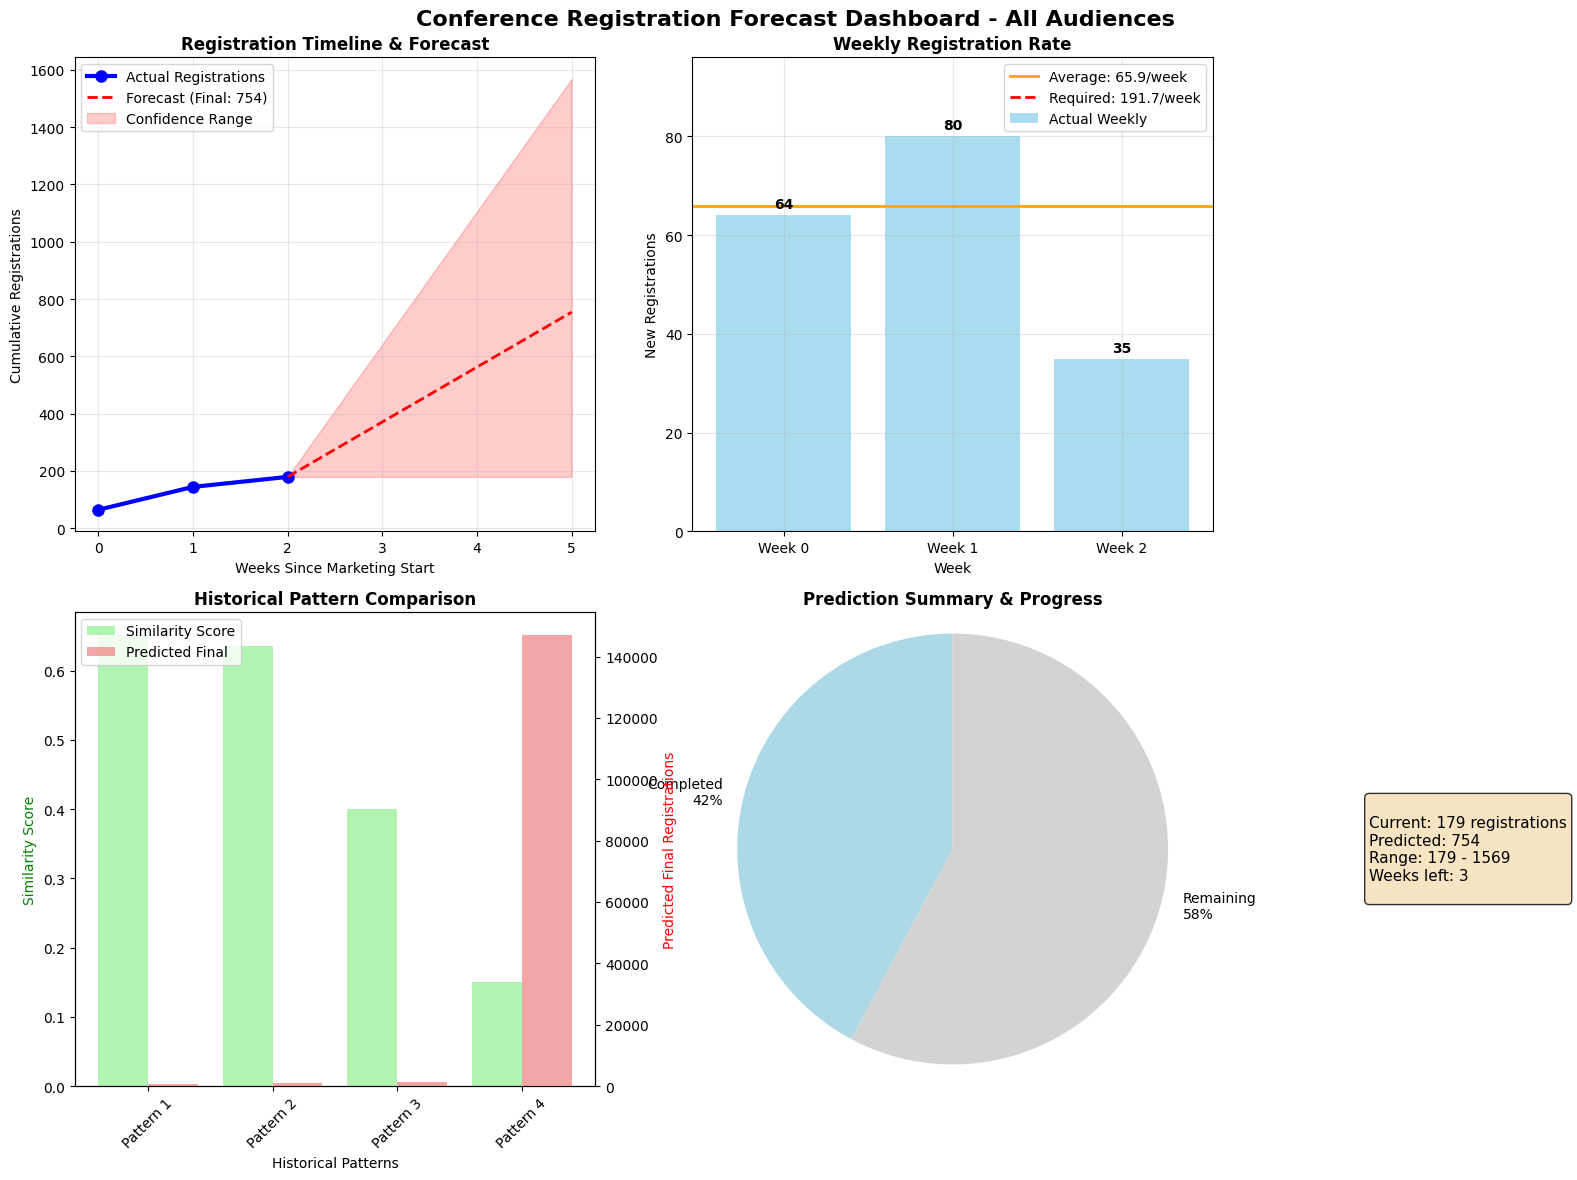


WEEKLY REGISTRATION VERIFICATION
Week-by-week breakdown (as displayed in graph):
  Week 0: 64 new registrations (Total: 64)
  Week 1: 80 new registrations (Total: 144)
  Week 2: 35 new registrations (Total: 179)


In [41]:
# =============================================================================
# VISUALIZATION DASHBOARD
# =============================================================================

def create_comprehensive_dashboard(current_data: Dict, predictions: Dict, matching_patterns: List[Dict], 
                                 date_info: Dict, user_config: Dict):
    """
    Create a comprehensive visualization dashboard.
    """
    if 'error' in current_data or 'error' in predictions:
        print("Cannot create dashboard due to data errors")
        return
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Conference Registration Forecast Dashboard - {user_config["target_audience"]}', 
                 fontsize=16, fontweight='bold')
    
    # Panel 1: Current vs. Predicted Timeline
    ax1.set_title('Registration Timeline & Forecast', fontweight='bold')
    
    current_weekly = current_data['weekly_data']
    weeks_elapsed = date_info['weeks_elapsed']
    weeks_remaining = date_info['weeks_remaining']
    total_weeks = weeks_elapsed + weeks_remaining
    
    # Current data
    if len(current_weekly) > 0:
        ax1.plot(current_weekly['Week'], current_weekly['CumulativeRegistrations'], 
                'o-', color='blue', linewidth=3, markersize=8, label='Actual Registrations')
    
    # Prediction line
    if weeks_remaining > 0:
        future_weeks = np.arange(weeks_elapsed, total_weeks + 1)
        current_total = predictions['current_total']
        final_prediction = predictions['ensemble_prediction']
        
        # Linear interpolation for forecast line
        future_values = np.linspace(current_total, final_prediction, len(future_weeks))
        ax1.plot(future_weeks, future_values, '--', color='red', linewidth=2, 
                label=f'Forecast (Final: {final_prediction:.0f})')
        
        # Confidence band
        low_values = np.linspace(current_total, predictions['low_estimate'], len(future_weeks))
        high_values = np.linspace(current_total, predictions['high_estimate'], len(future_weeks))
        ax1.fill_between(future_weeks, low_values, high_values, alpha=0.2, color='red', 
                        label='Confidence Range')
    
    ax1.set_xlabel('Weeks Since Marketing Start')
    ax1.set_ylabel('Cumulative Registrations')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Weekly Registration Rate - FIXED DATA DISPLAY
    ax2.set_title('Weekly Registration Rate', fontweight='bold')
    
    if len(current_weekly) > 0:
        # Ensure we're displaying the actual registration data correctly
        weeks = current_weekly['Week'].values
        registrations = current_weekly['Registrations'].values
        
        # Create bars with proper data mapping
        bars = ax2.bar(weeks, registrations, color='skyblue', alpha=0.7, label='Actual Weekly')
        
        # Add value labels on top of bars for clarity
        for i, (week, reg) in enumerate(zip(weeks, registrations)):
            ax2.text(week, reg + max(registrations) * 0.01, f'{int(reg)}', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Average line
        avg_rate = current_data['avg_weekly_rate']
        ax2.axhline(y=avg_rate, color='orange', linestyle='-', linewidth=2, 
                   label=f'Average: {avg_rate:.1f}/week')
        
        # Required future rate
        if weeks_remaining > 0:
            required_rate = predictions['additional_registrations_needed'] / weeks_remaining
            ax2.axhline(y=required_rate, color='red', linestyle='--', linewidth=2, 
                       label=f'Required: {required_rate:.1f}/week')
        
        # Set y-axis to start from 0 and show proper scale
        ax2.set_ylim(0, max(max(registrations) * 1.2, avg_rate * 1.2))
        
        # Ensure x-axis shows all weeks properly
        ax2.set_xticks(weeks)
        ax2.set_xticklabels([f'Week {int(w)}' for w in weeks])
    
    ax2.set_xlabel('Week')
    ax2.set_ylabel('New Registrations')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Panel 3: Pattern Matching Results
    ax3.set_title('Historical Pattern Comparison', fontweight='bold')
    
    if matching_patterns:
        pattern_names = [f"Pattern {i+1}" for i in range(min(5, len(matching_patterns)))]
        similarities = [p['similarity_score'] for p in matching_patterns[:5]]
        predictions_vals = [p['predicted_final'] for p in matching_patterns[:5]]
        
        # Create twin axis for predictions
        ax3_twin = ax3.twinx()
        
        bars1 = ax3.bar([i-0.2 for i in range(len(pattern_names))], similarities, 
                       width=0.4, color='lightgreen', alpha=0.7, label='Similarity Score')
        bars2 = ax3_twin.bar([i+0.2 for i in range(len(pattern_names))], predictions_vals, 
                           width=0.4, color='lightcoral', alpha=0.7, label='Predicted Final')
        
        ax3.set_xlabel('Historical Patterns')
        ax3.set_ylabel('Similarity Score', color='green')
        ax3_twin.set_ylabel('Predicted Final Registrations', color='red')
        ax3.set_xticks(range(len(pattern_names)))
        ax3.set_xticklabels(pattern_names, rotation=45)
        
        # Combine legends
        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    else:
        ax3.text(0.5, 0.5, 'No matching patterns found', ha='center', va='center', 
                transform=ax3.transAxes, fontsize=14)
        ax3.set_xticks([])
        ax3.set_yticks([])
    
    # Panel 4: Prediction Summary
    ax4.set_title('Prediction Summary & Progress', fontweight='bold')
    
    # Progress pie chart
    completion_pct = date_info['completion_percentage']
    remaining_pct = 100 - completion_pct
    
    pie_data = [completion_pct, remaining_pct]
    pie_labels = [f'Completed\n{completion_pct:.0f}%', f'Remaining\n{remaining_pct:.0f}%']
    colors = ['lightblue', 'lightgray']
    
    ax4.pie(pie_data, labels=pie_labels, colors=colors, autopct='', startangle=90)
    ax4.axis('equal')
    
    # Add text summary
    summary_text = f"""
Current: {predictions['current_total']} registrations
Predicted: {predictions['ensemble_prediction']:.0f}
Range: {predictions['low_estimate']:.0f} - {predictions['high_estimate']:.0f}
Weeks left: {weeks_remaining}
"""
    ax4.text(1.3, 0.5, summary_text, transform=ax4.transAxes, fontsize=11, 
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed weekly breakdown for verification
    print("\n" + "=" * 50)
    print("WEEKLY REGISTRATION VERIFICATION")
    print("=" * 50)
    print("Week-by-week breakdown (as displayed in graph):")
    for _, row in current_weekly.iterrows():
        week = int(row['Week'])
        registrations = int(row['Registrations'])
        cumulative = int(row['CumulativeRegistrations'])
        print(f"  Week {week}: {registrations} new registrations (Total: {cumulative})")
    print("=" * 50)

# Create comprehensive dashboard
create_comprehensive_dashboard(current_analysis, predictions, matching_patterns, date_info, user_config)

In [42]:
# =============================================================================
# RISK ASSESSMENT AND RECOMMENDATIONS
# =============================================================================

def generate_risk_assessment(current_data: Dict, predictions: Dict, date_info: Dict) -> Dict:
    """
    Generate risk assessment and actionable recommendations.
    """
    if 'error' in current_data or 'error' in predictions:
        return {'error': 'Cannot assess risk due to data errors'}
    
    current_total = predictions['current_total']
    predicted_final = predictions['ensemble_prediction']
    low_estimate = predictions['low_estimate']
    high_estimate = predictions['high_estimate']
    
    weeks_remaining = date_info['weeks_remaining']
    completion_pct = date_info['completion_percentage']
    
    assessment = {
        'risk_level': 'LOW',
        'confidence': 'HIGH',
        'risks': [],
        'opportunities': [],
        'recommendations': []
    }
    
    # Risk factors
    uncertainty_ratio = (high_estimate - low_estimate) / predicted_final
    
    if uncertainty_ratio > 0.4:
        assessment['confidence'] = 'LOW'
        assessment['risks'].append('High prediction uncertainty - wide confidence range')
    elif uncertainty_ratio > 0.2:
        assessment['confidence'] = 'MEDIUM'
        assessment['risks'].append('Moderate prediction uncertainty')
    
    # Timeline risks
    if weeks_remaining < 2:
        assessment['risk_level'] = 'HIGH'
        assessment['risks'].append('Very limited time remaining for adjustments')
    elif weeks_remaining < 4:
        assessment['risk_level'] = 'MEDIUM'
        assessment['risks'].append('Limited time for major marketing changes')
    
    # Pace analysis
    if weeks_remaining > 0:
        required_rate = predictions['additional_registrations_needed'] / weeks_remaining
        current_rate = current_data['recent_velocity']
        
        pace_ratio = required_rate / max(current_rate, 0.1)
        
        if pace_ratio > 2.0:
            assessment['risk_level'] = 'HIGH'
            assessment['risks'].append(f'Need to increase registration pace by {((pace_ratio - 1) * 100):.0f}%')
            assessment['recommendations'].append('Consider intensive marketing campaign or incentives')
        elif pace_ratio > 1.3:
            if assessment['risk_level'] == 'LOW':
                assessment['risk_level'] = 'MEDIUM'
            assessment['risks'].append(f'Need to increase registration pace by {((pace_ratio - 1) * 100):.0f}%')
            assessment['recommendations'].append('Consider boosting marketing efforts')
        elif pace_ratio < 0.7:
            assessment['opportunities'].append('Current pace is ahead of schedule - good position')
    
    # Data quality assessment
    if len(current_data['weekly_data']) < 3:
        assessment['confidence'] = 'LOW'
        assessment['risks'].append('Limited historical data for reliable prediction')
    
    # General recommendations
    if completion_pct < 25:
        assessment['recommendations'].append('Early stage - monitor closely and adjust marketing strategy')
    elif completion_pct < 75:
        assessment['recommendations'].append('Mid-campaign - optimize based on current performance')
    else:
        assessment['recommendations'].append('Late stage - focus on final push and conversion optimization')
    
    if uncertainty_ratio > 0.3:
        assessment['recommendations'].append('High uncertainty - plan for both optimistic and conservative scenarios')
    
    # Opportunities
    if predicted_final > current_total * 1.5:
        assessment['opportunities'].append('Strong growth potential - consider expanding capacity if needed')
    
    if len(assessment['risks']) == 0:
        assessment['opportunities'].append('All indicators positive - maintain current strategy')
    
    return assessment

# Generate risk assessment
risk_assessment = generate_risk_assessment(current_analysis, predictions, date_info)

if 'error' not in risk_assessment:
    print("\n" + "=" * 60)
    print("RISK ASSESSMENT & RECOMMENDATIONS")
    print("=" * 60)
    
    # Risk level indicator
    risk_colors = {'LOW': '🟢', 'MEDIUM': '🟡', 'HIGH': '🔴'}
    confidence_colors = {'HIGH': '🟢', 'MEDIUM': '🟡', 'LOW': '🔴'}
    
    print(f"\nOverall Assessment:")
    print(f"  Risk Level: {risk_colors.get(risk_assessment['risk_level'], '')} {risk_assessment['risk_level']}")
    print(f"  Confidence: {confidence_colors.get(risk_assessment['confidence'], '')} {risk_assessment['confidence']}")
    
    if risk_assessment['risks']:
        print(f"\n⚠️ Risk Factors:")
        for risk in risk_assessment['risks']:
            print(f"  • {risk}")
    
    if risk_assessment['opportunities']:
        print(f"\n✅ Opportunities:")
        for opportunity in risk_assessment['opportunities']:
            print(f"  • {opportunity}")
    
    if risk_assessment['recommendations']:
        print(f"\n💡 Recommendations:")
        for recommendation in risk_assessment['recommendations']:
            print(f"  • {recommendation}")
    
    print(f"\n📊 Quick Summary:")
    print(f"  • Current: {predictions['current_total']} registrations")
    print(f"  • Expected: {predictions['ensemble_prediction']:.0f} registrations")
    print(f"  • Range: {predictions['low_estimate']:.0f} - {predictions['high_estimate']:.0f}")
    print(f"  • Time remaining: {date_info['weeks_remaining']} weeks")
    print(f"  • Campaign: {date_info['completion_percentage']:.0f}% complete")
    
else:
    print(f"\nRisk Assessment Error: {risk_assessment['error']}")


RISK ASSESSMENT & RECOMMENDATIONS

Overall Assessment:
  Risk Level: 🔴 HIGH
  Confidence: 🔴 LOW

⚠️ Risk Factors:
  • High prediction uncertainty - wide confidence range
  • Limited time for major marketing changes
  • Need to increase registration pace by 233%

✅ Opportunities:
  • Strong growth potential - consider expanding capacity if needed

💡 Recommendations:
  • Consider intensive marketing campaign or incentives
  • Mid-campaign - optimize based on current performance
  • High uncertainty - plan for both optimistic and conservative scenarios

📊 Quick Summary:
  • Current: 179 registrations
  • Expected: 754 registrations
  • Range: 179 - 1569
  • Time remaining: 3 weeks
  • Campaign: 42% complete


## How to Use This System

### Quick Start:
1. **Update User Inputs**: Modify the values in the "USER INPUT INTERFACE" cell:
   - `selected_audience_idx`: Choose target audience (1-4) or 5 for "all"
   - `event_date`: Set your event date (DD/MM/YYYY format)
   - `marketing_start_date`: Set when marketing began

2. **Update Current Data**: Replace `sample_data.csv` with your latest registration data

3. **Run All Cells**: Execute the notebook to get real-time predictions

### Key Features:
- **Real-time Updates**: Easy to re-run with fresh registration data
- **Multiple Prediction Methods**: Pattern matching, velocity analysis, curve fitting
- **Confidence Intervals**: Low and high estimates for planning
- **Risk Assessment**: Automated alerts and recommendations
- **Visual Dashboard**: Comprehensive charts and progress tracking

### Understanding the Output:
- **Most Likely Total**: Best estimate based on ensemble of methods
- **Low/High Estimates**: Conservative and optimistic scenarios
- **Confidence Range**: Indicates prediction reliability
- **Risk Level**: GREEN (low risk), YELLOW (medium), RED (high risk)
- **Recommendations**: Actionable steps based on current situation

This system provides practical, data-driven insights for conference planning and marketing optimization.